# SMA Mini Project :
### Topic Modeling on App Reviews for Insights Using LDA

# Atharva Khanvilkar  
# D16AD - 33

In [23]:
!pip install google-play-scraper app-store-scraper pyLDAvis numpy gensim

In [24]:
# Imports

import pandas as pd

import json
from google_play_scraper import reviews, Sort
from app_store_scraper import AppStore

import spacy
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Scraping

In [25]:
total_reviews=1000

### Google Play Store reviews

In [26]:
def scrape_google_reviews(app_id, total_reviews=100):
    all_reviews = []
    count = 100  # batch size
    sort_order = Sort.NEWEST  # sort by new
    continuation_token = None

    while len(all_reviews) < total_reviews:
        try:
            rvws, continuation_token = reviews(
                app_id,
                lang='en',
                country='us',
                sort=sort_order,
                count=count,
                continuation_token=continuation_token
            )
            all_reviews.extend(rvws)
            if not continuation_token:
                break
        except Exception as e:
            print(f"An error occurred: {e}")
            break

    all_reviews = all_reviews[:total_reviews]
    df = pd.DataFrame(all_reviews)
    return df


In [27]:
google_reviews_df = scrape_google_reviews('com.whatsapp', total_reviews)
google_reviews_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,95026117-2ccf-4527-ae43-2bf5f044ee5d,Bahdon abiib muse Farax,https://play-lh.googleusercontent.com/a/ACg8oc...,WhatsApp,5,1,2.25.9.78,2025-04-13 21:04:07,None,None,2.25.9.78
1,481fab38-7530-4c7c-986b-558b705de346,Yogesh Goswami,https://play-lh.googleusercontent.com/a-/ALV-U...,Thank you 🙏,1,4,2.25.9.78,2025-04-13 20:25:09,None,None,2.25.9.78
2,dfe38e1e-7ab0-4c9b-8781-cdb9eadc89e3,Harikrishna Kommula,https://play-lh.googleusercontent.com/a/ACg8oc...,A.k,1,1,2.25.9.78,2025-04-13 20:06:27,None,None,2.25.9.78
3,7e3ebe53-80b2-4c50-a675-3b94ef89c98c,Ahmed Qureshi,https://play-lh.googleusercontent.com/a-/ALV-U...,❤️,5,0,2.25.9.78,2025-04-13 19:59:22,None,None,2.25.9.78
4,53382875-8922-4f0d-80b7-96ebc08a1dee,Adibest OG,https://play-lh.googleusercontent.com/a/ACg8oc...,is a nice app,5,2,None,2025-04-13 19:04:14,None,None,None


In [28]:
google_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              1000 non-null   object        
 1   userName              1000 non-null   object        
 2   userImage             1000 non-null   object        
 3   content               1000 non-null   object        
 4   score                 1000 non-null   int64         
 5   thumbsUpCount         1000 non-null   int64         
 6   reviewCreatedVersion  819 non-null    object        
 7   at                    1000 non-null   datetime64[ns]
 8   replyContent          0 non-null      object        
 9   repliedAt             0 non-null      object        
 10  appVersion            819 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 86.1+ KB


### Apple App Store Reviews

In [29]:
def scrape_apple_reviews(app_name, app_id, country='us', total_reviews=100):
    app = AppStore(country=country, app_name=app_name, app_id=app_id)
    app.review(how_many=total_reviews)

    reviews_df = pd.DataFrame(app.reviews)
    return reviews_df


In [30]:
apple_reviews_df = scrape_apple_reviews(app_name='whatsapp-messenger', app_id=310633997, total_reviews=total_reviews)
apple_reviews_df.head()

/usr/local/lib/python3.11/dist-packages/urllib3/util/ssl_.py:260: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated
  context = SSLContext(ssl_version or PROTOCOL_TLS)
/usr/local/lib/python3.11/dist-packages/urllib3/connection.py:407: DeprecationWarning: ssl.match_hostname() is deprecated
  match_hostname(cert, asserted_hostname)
/usr/local/lib/python3.11/dist-packages/urllib3/util/ssl_.py:260: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated
  context = SSLContext(ssl_version or PROTOCOL_TLS)
/usr/local/lib/python3.11/dist-packages/urllib3/connection.py:407: DeprecationWarning: ssl.match_hostname() is deprecated
  match_hostname(cert, asserted_hostname)
/usr/local/lib/python3.11/dist-packages/urllib3/util/ssl_.py:260: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated
  context = SSLContext(ssl_version or PROTOCOL_TLS)
/usr/local/lib/python3.11/dist-packages/urllib3/connection.py:407: DeprecationWarning: ssl.match_hostname() is deprecated
  match_hostname(cert, asserted_hostname)
/

,date,review,rating,isEdited,userName,title,developerResponse
0,2025-03-15 04:27:08,"I love this app, I basically use it most of th...",5,False,Vann smith,I love WhatsApp but why should I do?,NaN
1,2025-01-14 20:26:25,WhatsApp was what I used when I studied abroad...,1,False,Bigee14,"Filled with scammers, not a secure app",NaN
2,2025-01-17 02:27:30,"WhatsApp is an absolute disaster of an app, an...",1,False,issu564445,Absolutely horrible,NaN
3,2025-03-06 21:36:14,"Over the weekend, the app began showing a mess...",3,False,Bimbo Baggins 🧙‍♂️,Requires update but won’t download,NaN
4,2025-01-17 22:14:31,"Mark Zuckerberg founded Facebook, Instagram, T...",1,False,Amanda1217,Mark,NaN


In [31]:
apple_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               1000 non-null   datetime64[ns]
 1   review             1000 non-null   object        
 2   rating             1000 non-null   int64         
 3   isEdited           1000 non-null   bool          
 4   userName           1000 non-null   object        
 5   title              1000 non-null   object        
 6   developerResponse  47 non-null     object        
dtypes: bool(1), datetime64[ns](1), int64(1), object(4)
memory usage: 48.0+ KB


### Cleaning And Merging


In [32]:
# Cleaning

# Google Play store reviews
google_reviews_df = google_reviews_df.rename(columns={
    'score': 'rating',
    'at': 'date',
    'replyContent': 'developerResponse',
    'content': 'content'
})

google_reviews_df = google_reviews_df[['date', 'content', 'rating', 'userName', 'developerResponse']]
google_reviews_df['source'] = 'Google Play'

# Apple store reviews
apple_reviews_df = apple_reviews_df.rename(columns={
    'review': 'content'
})

apple_reviews_df = apple_reviews_df[['date', 'content', 'rating', 'userName', 'developerResponse']]
apple_reviews_df['source'] = 'Apple App Store'

# extract body from the JSON
def extract_developer_response(dev_response):
    if pd.isna(dev_response):
        return None

    if isinstance(dev_response, str):
        try:
            dev_response = json.loads(dev_response)
        except json.JSONDecodeError:
            return None

    return dev_response.get('body', None)


apple_reviews_df['developerResponse'] = apple_reviews_df['developerResponse'].apply(extract_developer_response)

apple_reviews_df[['content', 'developerResponse']].head()

,content,developerResponse
0,"I love this app, I basically use it most of th...",None
1,WhatsApp was what I used when I studied abroad...,None
2,"WhatsApp is an absolute disaster of an app, an...",None
3,"Over the weekend, the app began showing a mess...",None
4,"Mark Zuckerberg founded Facebook, Instagram, T...",None


In [33]:
#Merging

combined_reviews_df = pd.concat([google_reviews_df, apple_reviews_df], ignore_index=True)
combined_reviews_df = combined_reviews_df.sort_values(by='date', ascending=False).reset_index(drop=True)
combined_reviews_df.head()

,date,content,rating,userName,developerResponse,source
0,2025-04-13 21:04:07,WhatsApp,5,Bahdon abiib muse Farax,None,Google Play
1,2025-04-13 20:25:09,Thank you 🙏,1,Yogesh Goswami,None,Google Play
2,2025-04-13 20:06:27,A.k,1,Harikrishna Kommula,None,Google Play
3,2025-04-13 19:59:22,❤️,5,Ahmed Qureshi,None,Google Play
4,2025-04-13 19:04:14,is a nice app,5,Adibest OG,None,Google Play


In [34]:
combined_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               2000 non-null   datetime64[ns]
 1   content            2000 non-null   object        
 2   rating             2000 non-null   int64         
 3   userName           2000 non-null   object        
 4   developerResponse  47 non-null     object        
 5   source             2000 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 93.9+ KB


### Export to CSV

In [35]:
combined_reviews_df.to_csv('combined_reviews.csv', index=False)

print("CSV file has been saved as 'combined_reviews.csv'.")


CSV file has been saved as 'combined_reviews.csv'.


# Topic Modeling


In [36]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Preprocess function using spaCy for tokenization
def preprocess(text):
    doc = nlp(text.lower())
    # Tokenize
    return [token.text for token in doc if token.is_alpha and not token.is_stop]

In [37]:
texts = combined_reviews_df['content'].apply(preprocess)

# dictionary and corpus for LDA
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Applying LDA (Latent Dirichlet Allocation)
lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

In [38]:
# View topics
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.048*"good" + 0.015*"app" + 0.005*"service" + 0.005*"user" + 0.004*"people"')
(1, '0.048*"whatsapp" + 0.018*"phone" + 0.015*"number" + 0.010*"account" + 0.008*"message"')
(2, '0.034*"app" + 0.027*"whatsapp" + 0.016*"like" + 0.011*"use" + 0.010*"status"')
(3, '0.034*"whatsapp" + 0.014*"app" + 0.013*"ai" + 0.009*"iphone" + 0.009*"want"')
(4, '0.034*"app" + 0.028*"whatsapp" + 0.017*"phone" + 0.011*"account" + 0.008*"number"')


### Visualisation

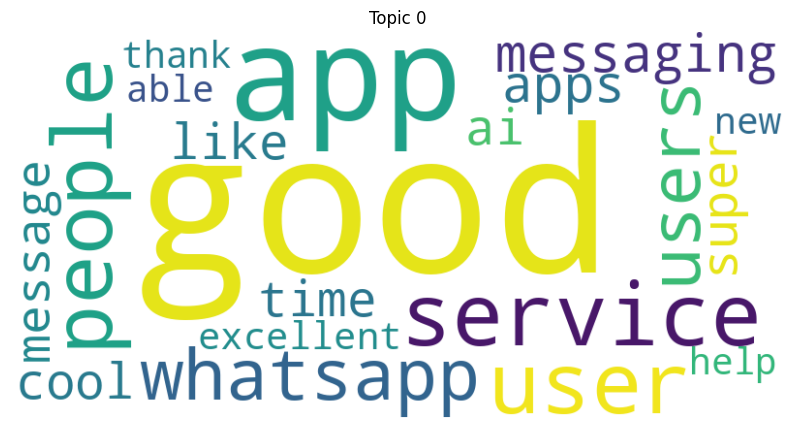

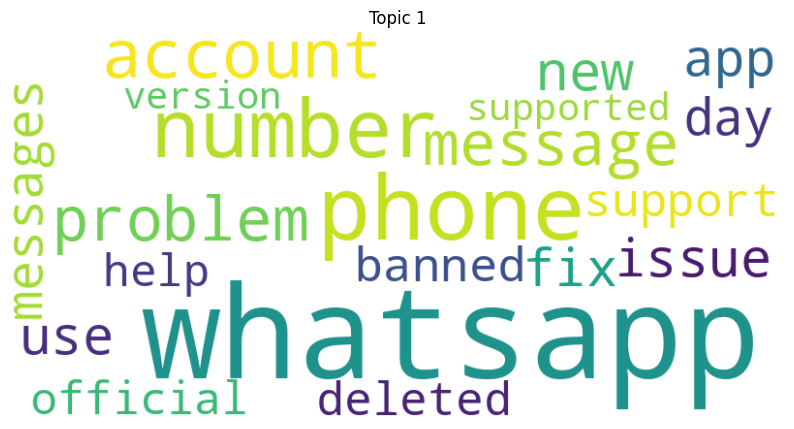

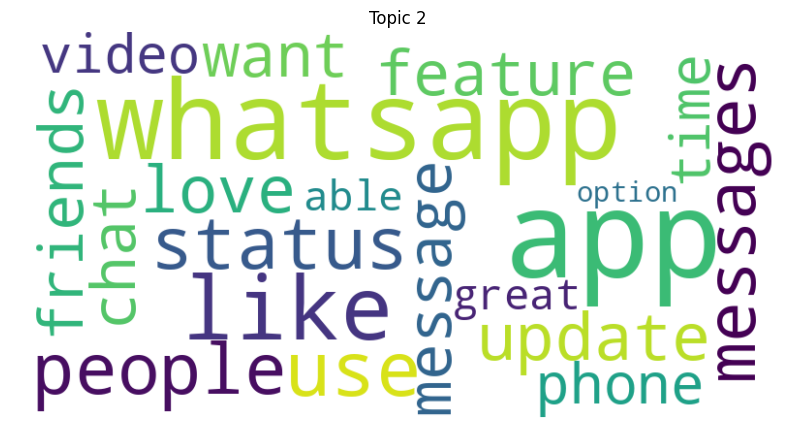

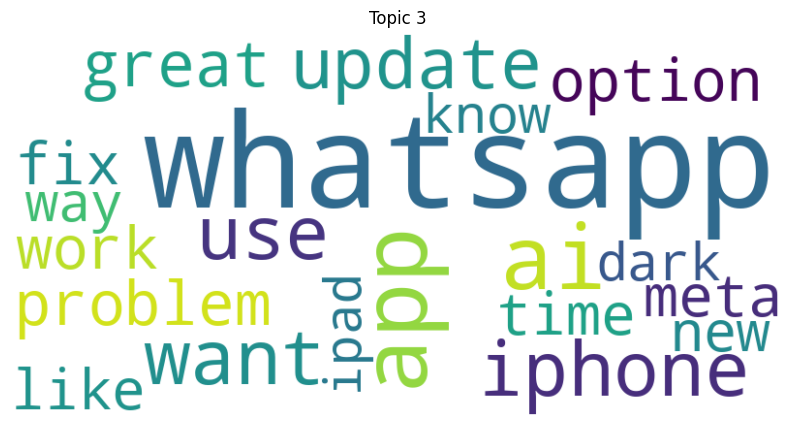

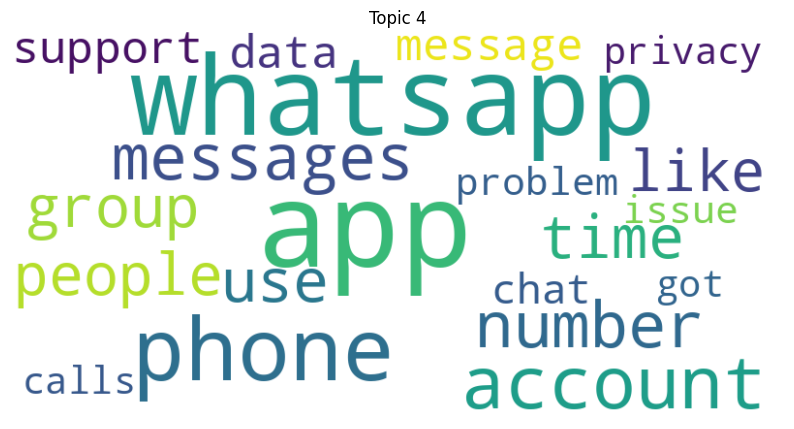

In [39]:
# Generate word clouds for each topic
for i in range(lda_model.num_topics):
    plt.figure(figsize=(10, 8))
    # Get the top 20 words for each topic
    words = lda_model.show_topic(i, topn=20)  # Use 'topn' instead of 'num_words'

    # Create the word cloud from the frequencies
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(words))

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Topic {i}')
    plt.axis('off')  # Hide axes
    plt.show()


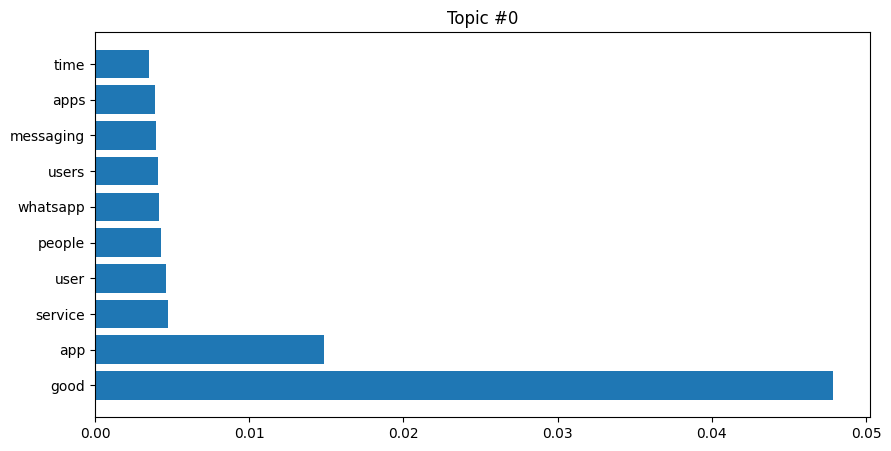

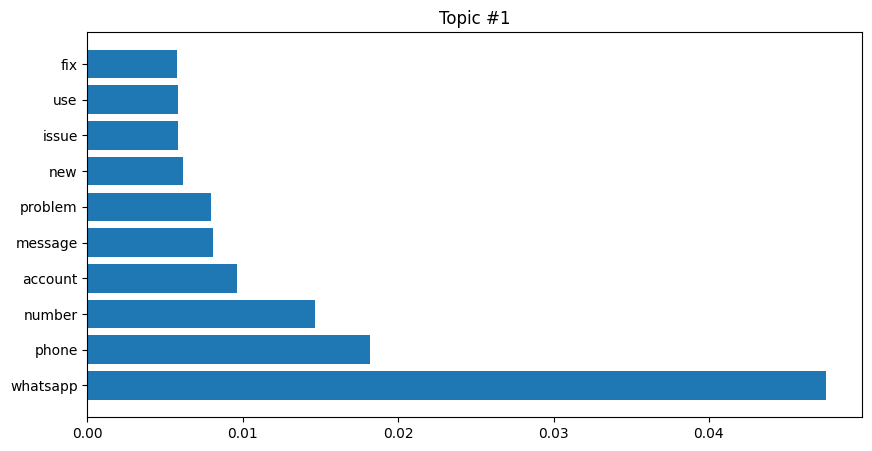

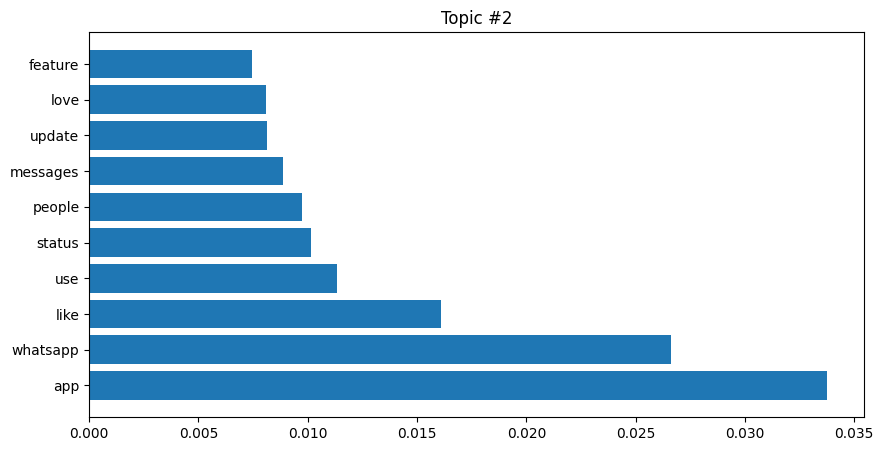

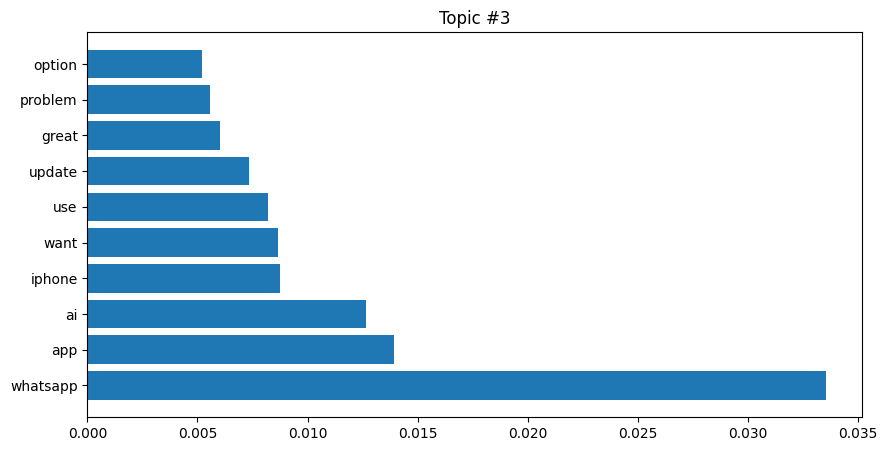

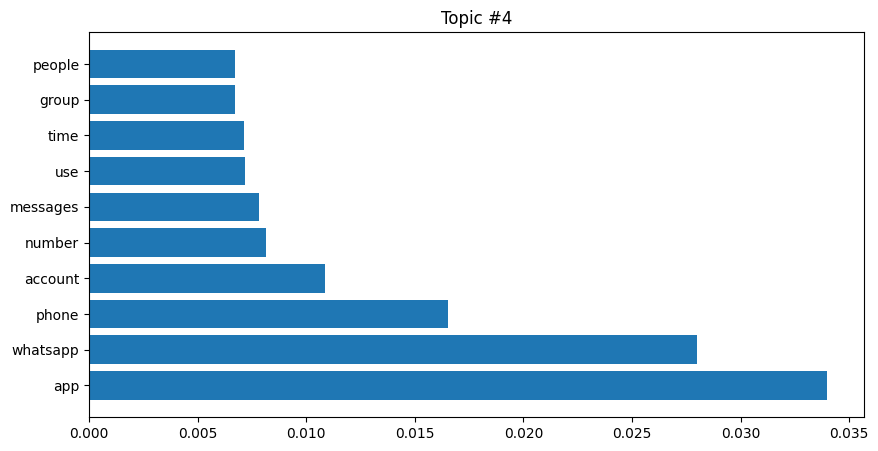

In [40]:
# Plot the top words for each topic
num_words = 10
for i in range(lda_model.num_topics):
    plt.figure(figsize=(10, 5))
    words = lda_model.show_topic(i, topn=num_words)
    words = [word[0] for word in words]
    plt.barh(range(num_words), [word[1] for word in lda_model.show_topic(i, topn=num_words)])
    plt.yticks(range(num_words), words)
    plt.title(f"Topic #{i}")
    plt.show()
